In [24]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#gsm modes
# process_gen_mode="llama_gsm_sample"
# compare_metric='final_num_exact_match'


#wmt modes

# process_gen_mode="wmt_beam8"
# process_gen_mode="wmt_top_k"
compare_metric="example_comet"


process_gen_mode="wmt_beam128"
compare_metric="BLEU_4"


# process_gen_mode="wmt_beam128"
# compare_metric="BLEU_4"

#instruct modes
# process_gen_mode="instruct8"
# compare_metric="example_themis"

do_norm_analysis=True
processGens.init_with_mode(process_gen_mode,print_files=True)


root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics = processGens.get_params()

examples_df, completions_df=get_dfs(processGens)





Init: process_gens_mode wmt_beam128
calculate_gen_summary_dict
snellius_copies/helm_output/sample_1_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/128_beams/runs/sample_1_eval_1000
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['beam_num', 'task_name', 'model', 'example_idx', 'suite', 'instanceID',
       'text', 'completion_length', 'output_logprob', 'isCompletion', 'BLEU_1',
       'BLEU_4', 'comet'],
      dtype='object')
Num examples: 128000
Num completions: 1000


KeyError: 'Column not found: example_comet'

In [32]:
compare_metric="BLEU_4"
print(examples_df.columns)
do_norm_analysis=False


Index(['beam_num', 'task_name', 'model', 'example_idx', 'suite', 'instanceID',
       'text', 'completion_length', 'output_logprob', 'isCompletion', 'BLEU_1',
       'BLEU_4', 'comet'],
      dtype='object')


In [33]:

if(do_norm_analysis):
    for col in [compare_metric, 'output_logprob']:
        examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )

dfs_by_model={}


for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df
    print(f"model_name {model_name} filtered_df len",len(filtered_df))

all_dfs_by_model=dfs_by_model
if(len(models)>1):
    all_dfs_by_model["all_models"]=examples_df



print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

model_name meta_llama_Llama_3.1_8B_Instruct filtered_df len 128000
	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [128] 
 	 models: ['meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_1_eval_1000 
 	 instance_metrics ['comet']
   beam_num                    task_name                             model  \
0       128  wmt_14_language_pair_de_en_  meta_llama_Llama_3.1_8B_Instruct   
1       128  wmt_14_language_pair_de_en_  meta_llama_Llama_3.1_8B_Instruct   

   example_idx               suite  instanceID  \
0            0  sample_1_eval_1000           0   
1            1  sample_1_eval_1000           0   

                                                text  completion_length  \
0  He advised the parents of a boy whose penis ha...                174   
1  He advised the parents of a boy whose penis ha...                178   

   output_logprob isCompletion    BLEU_1    BLEU_4    

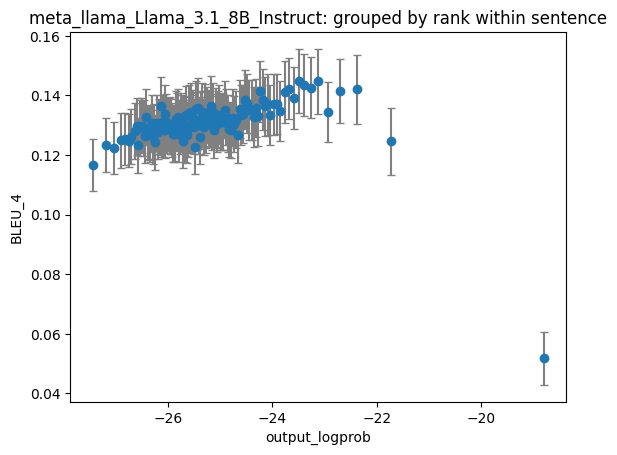

In [35]:
def plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
    





plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None

for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs

    
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    
    # print("len filtered_df ",len(filtered_df))
    # plot by rank within sentence
    suptitle="grouped by rank within sentence"
    plot_grouped(df=filtered_df, xlabel="output_logprob", groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax)
    

    # plot 
    
    # suptitle="Raw Plotting Probability vs Quality"
    # plot_keys(df=examples_df, xlabel='output_logprob', ylabel=compare_metric, title=calculate_title(), ax=ax)


    # # just plot metric / probability (normalized) 
    # suptitle="Normalized Probability vs Quality"
    # plot_keys(df=filtered_df, xlabel='output_logprob_norm', ylabel=compare_metric+'_norm', title=calculate_title(), ax=ax)

    # # plot: group into equally-sized bins (ignores examples example_id)
    # suptitle="Grouped with equal bins (by logprob)"
    # plot_grouped(df=filtered_df, xlabel="output_logprob", groupby="bins", ylabel=compare_metric, title=calculate_title(), ax=ax, nbins=10)

    # suptitle="Grouped with equal bins (by logprob)"
    # plot_grouped(df=filtered_df, xlabel='output_logprob_norm',  groupby="bins", ylabel=compare_metric+'_norm', title=calculate_title(), ax=ax, nbins=10)

    # # suptitle="Grouped by reference sentence"
    # instance_df=filtered_df.groupby("instanceID")[["output_logprob", compare_metric]].mean()
    # suptitle="Grouped by reference sentence"
    # plot_keys(df=instance_df, xlabel='output_logprob', ylabel=compare_metric, title=calculate_title(), ax=ax)
    
    # suptitle="Grouped by reference sentence"
    # plot_grouped(df=instance_df, xlabel='output_logprob',  groupby="bins", ylabel=compare_metric, title=calculate_title(), ax=ax, nbins=10)
    
if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    

1000
